# TELSEM2 Surface Emissivities

This notebook creates a map of mircrowave surface emissivities calculated using the ARTS interface to TELSEM2.

In [1]:
%env ARTS_INCLUDE_PATH=/home/simonpf/src/arts/controlfiles/
%env ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
%env ARTS_BUILD_PATH=/home/simonpf/build/arts/

import sys
sys.path.append("..")
sys.path.append("/home/simonpf/src/typhon/")
import utils.setup
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

env: ARTS_INCLUDE_PATH=/home/simonpf/src/arts/controlfiles/
env: ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
env: ARTS_BUILD_PATH=/home/simonpf/build/arts/


In [2]:
from mpl_toolkits.basemap import Basemap

def plot_global_map(lat, lon, z, ax = None, norm = None):
    m = Basemap(projection='cyl', ax = ax, lon_0 = 180.0, lat_0 = 0.0)
    m.drawcoastlines()
    
    if ax is None:
        ax = plt.gca()
    
    LON, LAT = np.meshgrid(lon, lat)
    x, y = m(LON, LAT)
    ax.pcolormesh(x, y, z, shading = "gouraud", norm = norm)
    
    parallels = np.arange(-90.0, 90, 30.0)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    
    # draw meridians
    meridians = np.arange(0.0, 360.0, 60.0)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

## Workspace Setup

To compute emissivities we will only execute surface_rtprop_agenda so only a minimal setup of the ARTS workspace is required. We use a one-dimensional atmosphere and stokes dimension two since we are interested
in polarization.

In [3]:
from typhon.arts.workspace import Workspace

ws = Workspace()
ws.AtmosphereSet1D()
ws.stokes_dim     = 2

Loading ARTS API from: /home/simonpf/build/arts/src/libarts_api.so


We are computing emissivities at frequencies of 6 to 664 GHz to span a large part of the validity range of TELSEM2.

In [4]:
ws.f_grid = np.array([6.0, 19.0, 85.0, 183.0, 243.0, 325.0, 448.0, 664.0]) * 1e9

## Loading a Telsem Atlas

The TELSEM2 emissivity is contained in 12 atlases containing monthly averages of SSM/I-derived surface emissivities for each month of the year. To load the data, we creat an ARTS WSV to hold the atlas and read the atlas using the telsem_atlasReadAscii WSM. Here we load the atlas for February.

In [5]:
ws.TelsemAtlasCreate("telsem_atlas")
ws.telsem_atlasReadAscii(ws.telsem_atlas, "/home/simonpf/src/telsem2/Atlas/", 2)

In [6]:
from typhon.arts.workspace import arts_agenda

ws.NumericCreate("surface_t")

@arts_agenda
def surface_telsem(ws):
    ws.Copy(ws.surface_skin_t, ws.surface_t)
    ws.Ignore(ws.surface_los)
    ws.surfaceTelsem(atlas = ws.telsem_atlas)
    
ws.surface_rtprop_agenda = surface_telsem

## Loading the Climatology

The surface temperatures and and wind speeds are taken from ERA Interim data for Valentine's day 2017 (2017-02-14).

In [7]:
file = np.load("data/climatology.npz")
lat  = file['lat']
lon  = file['lon']
sst  = file['sst']
skt  = file['skt']
wv   = file['ws']

## Creating the Map

To create the emissivity maps we loop over the latitudes and longitudes in the climatology and call the **surface_rtprop_agenda**. **surfaceTelsem** throws an error if the users tries to compute emissivities for a cell that is not in the atlas, i.e. that is above the ocean. To avoid this we check if a given cell is in the atlas using the **telsem_atlasSurfaceTypeLandSea** workspace method.

In [8]:
es = np.zeros((lat.size, lon.size, np.asarray(ws.f_grid).size, 2))

ws.VectorSet(ws.lat_grid, np.array([]))
ws.VectorSet(ws.lon_grid, np.array([]))
ws.lon_grid = np.array([])
ws.rtp_pos = np.array([0.0])
ws.rtp_los = np.array([160.0])
ws.surface_los = np.array([[0.0]])
        
for i in range(lat.size):
    for j in range(lon.size):
        ws.lat_true = np.array([lat[i]])
        ws.lon_true = np.array([lon[j]])
        
        ws.telsemSurfaceTypeLandSea(atlas = ws.telsem_atlas)
        if (ws.surface_type.value == 1):
            ws.surface_t = skt[i, j]
            ws.AgendaExecute(ws.surface_rtprop_agenda)
            rv = ws.surface_rmatrix.value[0, :, 0, 0] + ws.surface_rmatrix.value[0, :, 0, 1]
            rh = ws.surface_rmatrix.value[0, :, 0, 0] - ws.surface_rmatrix.value[0, :, 0, 1]
            es[i, j, :, 0] = 1.0 - rv
            es[i, j, :, 1] = 1.0 - rh


/home/simonpf/build/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


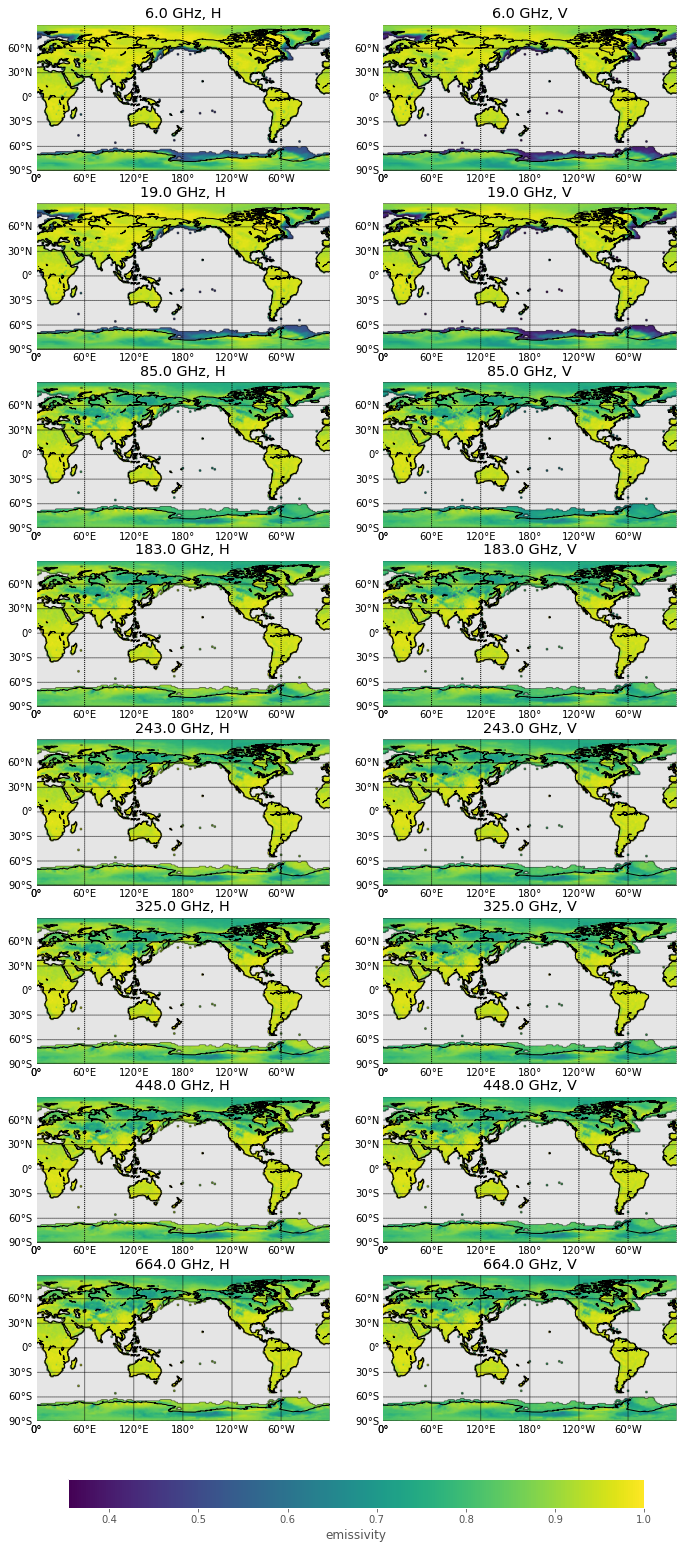

In [10]:
import matplotlib as mpl

es_masked = np.ma.MaskedArray(es, mask = es == 0.0)
norm = mpl.colors.Normalize(vmin = es_masked.min(), vmax = es_masked.max())
cmap = mpl.cm.ScalarMappable(norm = norm)
cmap.set_array(es_masked)
freqs = ["6.0", "19.0", "85.0", "183.0", "243.0", "325.0", "448.0", "664.0"]
pols  = ["H", "V"]

f, axs = plt.subplots(8, 2, figsize = (10, 20))
for i in range(8):
    for j in range(2):
        plot_global_map(lat, lon, es_masked[:, :, i, j], ax = axs[i, j], norm = norm)
        axs[i, j].set_title(freqs[i] + " GHz, " + pols[j])
        
cax = f.add_axes([0.1, -0.05, 0.8, 0.02])        
f.colorbar(cmap, cax = cax, orientation = "horizontal", label = "emissivity")
plt.tight_layout()        
f.savefig("telsem_emissivities.pdf", bbox_inches = "tight")